# Burnup Study - Packing Factor 0.5

The purpose of this notebook is to carry out a burnup analysis of the Graphite moderated gas-cooled reactor with TRISO particles in prismatic compacts.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="fuel_compact")
fuel.set_density('atom/b-cm',8.26793e-2) # To Do: implement a better method for adjusting triso fuel parameters
fuel.add_nuclide('U235',3.5464306e-4)
fuel.add_nuclide('U238',1.420345e-3)
fuel.add_element('C',7.30472004e-2)
fuel.add_element('O',3.5464306-3)
fuel.add_element('S',4.31248291e-3)
fuel.add_s_alpha_beta('c_Graphite')

coolant = openmc.Material(name='He')
coolant.set_density('g/cm3',1.86e-3) # at 3MPa, 500 C (need to fix)
coolant.add_element('He',1.0)
 # no s_alpha_beta for Helium??
    
    
mod = openmc.Material(name='Graphite')
mod.set_density('g/cm3',1.7)
mod.add_element('C',1)
mod.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([fuel,coolant,mod]);

## Pin Cell Geometry

The goal is to establish a pin-cell to provide a simplified representation of the basic criticality and (especially) neutron energy spectrum for this concept.  

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.6; #cm, radius of fuel compact
r_channel = 0.8;#cm, radius of fuel channel 

P_D = 1.58

pitch = P_D*(2*r_channel);

fuel_temp = 1200; # K, representative fuel temperature (?)
mod_temp = 800; # K, representative moderator temperature (?)

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# channel cylinder
channel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2+1.],
                                            h_core-2.,r_channel);
# avoid coincident boundaries with the core cell

# core cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


channel_cell = openmc.Cell();
channel_cell.region = +fuel_cyl & -channel_cyl;
channel_cell.fill = coolant;

mod_cell = openmc.Cell();
mod_cell.region = +channel_cyl & -core_cell;
mod_cell.fill = mod
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,channel_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

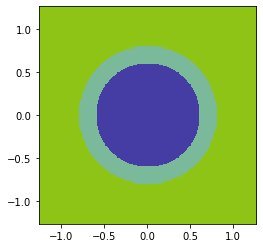

In [5]:
root_univ.plot(width=(pitch,pitch));

In [6]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()


In [7]:
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml")
power = 1e4;
days = 24*3600;
time_steps = [0.1*days, 0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days,365.*days,365.*days,365.*days,730.*days,730.*days]

integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5


 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/sblair/OMC_DATA/endfb71_hdf5/V50.h5
 Reading V51 from /home/sblair/OMC_DATA/endfb71_hdf5/V51.h5
 Reading Cr50 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr50.h5
 Reading Cr52 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr52.h5
 Reading Cr5

 Reading Se80 from /home/sblair/OMC_DATA/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading

 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endf

          1200K
          2500K


 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn117.h5
 Reading Sn118 from /home/sblair/O

          1200K
          2500K


 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5


          1200K
          2500K


 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Bk250 from /home/sblair/OMC_DATA/endfb71_hdf5/Bk250.h5
 Reading Cf246 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5


          1200K


 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.63855
        2/1    1.64127
        3/1    1.64352
        4/1    1.64631
        5/1    1.64321
        6/1    1.63699
        7/1    1.63053
        8/1    1.63609
        9/1    1.64958
       10/1    1.64550
       11/1    1.65540
       12/1    1.64313
       13/1    1.63474
       14/1    1.63738
       15/1    1.64768
       16/1    1.64443
       17/1    1.63021
       18/1    1.64128
       19/1    1.65580
       20/1    1.64239
       21/1    1.65988
       22/1    1.64483
       23/1    1.65350
       24/1    1.64621
       25/1    1.63500
       26/1    1.65477
       27/1    1.64742
       28/1    1.64214
       29/1    1.65659
       30/1    1.65395
       31/1    1.61929
       32/1    1.66220
       33/1    1.67675
       34/1    1.61772
       35/1    1.62

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.61921
        2/1    1.63164
        3/1    1.63506
        4/1    1.64409
        5/1    1.62926
        6/1    1.62276
        7/1    1.63420
        8/1    1.65423
        9/1    1.64451
       10/1    1.62489
       11/1    1.63524
       12/1    1.61131
       13/1    1.62474
       14/1    1.65538
       15/1    1.63201
       16/1    1.64107
       17/1    1.60911
       18/1    1.62679
       19/1    1.61451
       20/1    1.62202
       21/1    1.64161
       22/1    1.62444
       23/1    1.62554
       24/1    1.63241
       25/1    1.66322
       26/1    1.63145
       27/1    1.63723
       28/1    1.60821
       29/1    1.63597
       30/1    1.62766
       31/1    1.63963
       32/1    1.64446
       33/1    1.61068
       34/1    1.62262
       35/1    1.63

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.61139
        2/1    1.62638
        3/1    1.62421
        4/1    1.61832
        5/1    1.61067
        6/1    1.62576
        7/1    1.62390
        8/1    1.60293
        9/1    1.61897
       10/1    1.64304
       11/1    1.61647
       12/1    1.63818
       13/1    1.62376
       14/1    1.61763
       15/1    1.61559
       16/1    1.62274
       17/1    1.61723
       18/1    1.61278
       19/1    1.60205
       20/1    1.61664
       21/1    1.61015
       22/1    1.61259
       23/1    1.60972
       24/1    1.61491
       25/1    1.63581
       26/1    1.62162
       27/1    1.62534
       28/1    1.58164
       29/1    1.61258
       30/1    1.62368
       31/1    1.62234
       32/1    1.63355
       33/1    1.60285
       34/1    1.61717
       35/1    1.62

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.57719
        2/1    1.61283
        3/1    1.58842
        4/1    1.60648
        5/1    1.62746
        6/1    1.58000
        7/1    1.59028
        8/1    1.60460
        9/1    1.57481
       10/1    1.61009
       11/1    1.59508
       12/1    1.59603
       13/1    1.59443
       14/1    1.57672
       15/1    1.57729
       16/1    1.57504
       17/1    1.58247
       18/1    1.58806
       19/1    1.58151
       20/1    1.59170
       21/1    1.59053
       22/1    1.56022
       23/1    1.58900
       24/1    1.56992
       25/1    1.57134
       26/1    1.57977
       27/1    1.59378
       28/1    1.59121
       29/1    1.58101
       30/1    1.59586
       31/1    1.61801
       32/1    1.59416
       33/1    1.58845
       34/1    1.58355
       35/1    1.58

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.60615
        2/1    1.58375
        3/1    1.59700
        4/1    1.55992
        5/1    1.59140
        6/1    1.56467
        7/1    1.55968
        8/1    1.56502
        9/1    1.57213
       10/1    1.57573
       11/1    1.56609
       12/1    1.57073
       13/1    1.57997
       14/1    1.56734
       15/1    1.57979
       16/1    1.55273
       17/1    1.56484
       18/1    1.54897
       19/1    1.55549
       20/1    1.57983
       21/1    1.57519
       22/1    1.53893
       23/1    1.56563
       24/1    1.57068
       25/1    1.58653
       26/1    1.57971
       27/1    1.56478
       28/1    1.56973
       29/1    1.57950
       30/1    1.57401
       31/1    1.56514
       32/1    1.57525
       33/1    1.56923
       34/1    1.56631
       35/1    1.56

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.56060
        2/1    1.55595
        3/1    1.56949
        4/1    1.56619
        5/1    1.57834
        6/1    1.58579
        7/1    1.56064
        8/1    1.53356
        9/1    1.57295
       10/1    1.56992
       11/1    1.56173
       12/1    1.54759
       13/1    1.57056
       14/1    1.56262
       15/1    1.56547
       16/1    1.54177
       17/1    1.57153
       18/1    1.56241
       19/1    1.57339
       20/1    1.55934
       21/1    1.55804
       22/1    1.54030
       23/1    1.57169
       24/1    1.55314
       25/1    1.54955
       26/1    1.56062
       27/1    1.53936
       28/1    1.54466
       29/1    1.57723
       30/1    1.55496
       31/1    1.57124
       32/1    1.55159
       33/1    1.55576
       34/1    1.53750
       35/1    1.56

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.52885
        2/1    1.50738
        3/1    1.51971
        4/1    1.52827
        5/1    1.52970
        6/1    1.50801
        7/1    1.51922
        8/1    1.52047
        9/1    1.51140
       10/1    1.52736
       11/1    1.52518
       12/1    1.52832
       13/1    1.53977
       14/1    1.52532
       15/1    1.52889
       16/1    1.52664
       17/1    1.50772
       18/1    1.53133
       19/1    1.48748
       20/1    1.51550
       21/1    1.52534
       22/1    1.49915
       23/1    1.52414
       24/1    1.50910
       25/1    1.51598
       26/1    1.51656
       27/1    1.50931
       28/1    1.54483
       29/1    1.52482
       30/1    1.51187
       31/1    1.51461
       32/1    1.51200
       33/1    1.50031
       34/1    1.50392
       35/1    1.54

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.51106
        2/1    1.46563
        3/1    1.50078
        4/1    1.48567
        5/1    1.50103
        6/1    1.48666
        7/1    1.47562
        8/1    1.50280
        9/1    1.49141
       10/1    1.47851
       11/1    1.49932
       12/1    1.47907
       13/1    1.50209
       14/1    1.49514
       15/1    1.47755
       16/1    1.48584
       17/1    1.48748
       18/1    1.47090
       19/1    1.50471
       20/1    1.48817
       21/1    1.47107
       22/1    1.46665
       23/1    1.49388
       24/1    1.49207
       25/1    1.49393
       26/1    1.50288
       27/1    1.48855
       28/1    1.49026
       29/1    1.47054
       30/1    1.50169
       31/1    1.51002
       32/1    1.49355
       33/1    1.49777
       34/1    1.48779
       35/1    1.48

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.37811
        2/1    1.38924
        3/1    1.36512
        4/1    1.38573
        5/1    1.36792
        6/1    1.38174
        7/1    1.35645
        8/1    1.38263
        9/1    1.36873
       10/1    1.37231
       11/1    1.38361
       12/1    1.36760
       13/1    1.36739
       14/1    1.35533
       15/1    1.37017
       16/1    1.37119
       17/1    1.39089
       18/1    1.36171
       19/1    1.36168
       20/1    1.34838
       21/1    1.37246
       22/1    1.36787
       23/1    1.37873
       24/1    1.37510
       25/1    1.36664
       26/1    1.37500
       27/1    1.37524
       28/1    1.37555
       29/1    1.37998
       30/1    1.36599
       31/1    1.38821
       32/1    1.38539
       33/1    1.38136
       34/1    1.38995
       35/1    1.36

 Maximum neutron transport energy: 8100000.0 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.94209
        2/1    0.95055
        3/1    0.94350
        4/1    0.94712
        5/1    0.94352
        6/1    0.94704
        7/1    0.93878
        8/1    0.95844
        9/1    0.95238
       10/1    0.95297
       11/1    0.95353
       12/1    0.95735
       13/1    0.93655
       14/1    0.94184
       15/1    0.95290
       16/1    0.94546
       17/1    0.94424
       18/1    0.95906
       19/1    0.93901
       20/1    0.94474
       21/1    0.93633
       22/1    0.95242
       23/1    0.94056
       24/1    0.95275
       25/1    0.93942
       26/1    0.94821
       27/1    0.95684
       28/1    0.95394
       29/1    0.94992
       30/1    0.96333
       31/1    0.94209
       32/1    0.94303
       33

      200/1    0.95587    0.94798 +/- 0.00063
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.8832e+03 seconds
   Time in transport only          = 5.8821e+03 seconds
   Time in inactive batches        = 1.1411e+03 seconds
   Time in active batches          = 4.7420e+03 seconds
   Time synchronizing fission bank = 6.2270e-01 seconds
     Sampling source sites         = 5.6685e-01 seconds
     SEND/RECV source sites        = 5.4639e-02 seconds
   Time accumulating tallies       = 1.6615e-01 seconds
   Time writing statepoints        = 1.6981e-02 seconds
 Total time for finalization       = 2.7403e-03 seconds
 Total time elapsed                = 5.8836e+03 seconds
 Calculation Rate (inactive)       = 876.331 particles/second
 Calculation Rate (active)         = 632.6

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.54887
        2/1    0.56319
        3/1    0.56738
        4/1    0.56280
        5/1    0.55772
        6/1    0.56620
        7/1    0.56871
        8/1    0.56053
        9/1    0.56571
       10/1    0.57069
       11/1    0.56483
       12/1    0.56285
       13/1    0.56704
       14/1    0.55629
       15/1    0.55762
       16/1    0.55452
       17/1    0.56424
       18/1    0.57464
       19/1    0.57037
       20/1    0.57056
       21/1    0.56712
       22/1    0.56353
       23/1    0.55839
       24/1    0.56816
       25/1    0.56532
       26/1    0.56004
       27/1    0.55878
       28/1    0.57183
       29/1    0.56354
       30/1    0.56103
       31/1    0.56112
       32/1    0.57340
       33/1    0.56369
       34/1    0.56811
       35/1    0.56

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.42959
        2/1    0.44132
        3/1    0.43421
        4/1    0.43726
        5/1    0.43363
        6/1    0.43196
        7/1    0.43610
        8/1    0.43203
        9/1    0.43929
       10/1    0.43523
       11/1    0.43536
       12/1    0.43935
       13/1    0.44071
       14/1    0.43846
       15/1    0.43817
       16/1    0.43222
       17/1    0.43452
       18/1    0.43755
       19/1    0.43547
       20/1    0.43140
       21/1    0.43959
       22/1    0.44128
       23/1    0.43362
       24/1    0.43768
       25/1    0.43552
       26/1    0.43965
       27/1    0.43621
       28/1    0.43890
       29/1    0.43137
       30/1    0.42628
       31/1    0.43741
       32/1    0.43044
       33/1    0.43609
       34/1    0.43658
       35/1    0.43

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.30138
        2/1    0.30627
        3/1    0.30753
        4/1    0.30771
        5/1    0.30788
        6/1    0.30891
        7/1    0.30759
        8/1    0.30548
        9/1    0.30846
       10/1    0.30643
       11/1    0.30661
       12/1    0.30382
       13/1    0.30630
       14/1    0.30451
       15/1    0.30277
       16/1    0.30699
       17/1    0.30980
       18/1    0.30657
       19/1    0.30248
       20/1    0.30328
       21/1    0.30383
       22/1    0.30389
       23/1    0.30581
       24/1    0.30498
       25/1    0.30578
       26/1    0.30651
       27/1    0.30357
       28/1    0.30769
       29/1    0.30701
       30/1    0.30799
       31/1    0.30509
       32/1    0.30547
       33/1    0.30626
       34/1    0.30796
       35/1    0.30

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.13853
        2/1    0.13972
        3/1    0.14132
        4/1    0.14004
        5/1    0.13957
        6/1    0.14107
        7/1    0.13908
        8/1    0.14265
        9/1    0.13889
       10/1    0.14064
       11/1    0.14104
       12/1    0.13876
       13/1    0.14020
       14/1    0.13971
       15/1    0.14022
       16/1    0.14067
       17/1    0.13970
       18/1    0.14186
       19/1    0.14089
       20/1    0.13896
       21/1    0.14129
       22/1    0.14108
       23/1    0.14055
       24/1    0.14045
       25/1    0.14000
       26/1    0.14092
       27/1    0.14069
       28/1    0.14016
       29/1    0.13967
       30/1    0.14155
       31/1    0.13927
       32/1    0.14181
       33/1    0.14051
       34/1    0.14169
       35/1    0.14

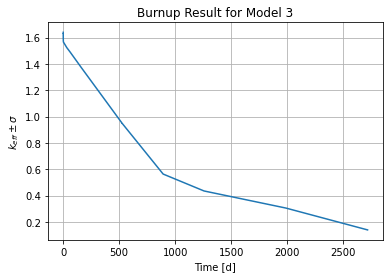

In [8]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

time,k = results.get_eigenvalue()
time /= (24*60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for Model 3')
plt.xlabel('Time [d]')
plt.ylabel('$k_{eff} \pm \sigma$')
plt.grid()



Text(0, 0.5, 'Number of atoms Cs137')

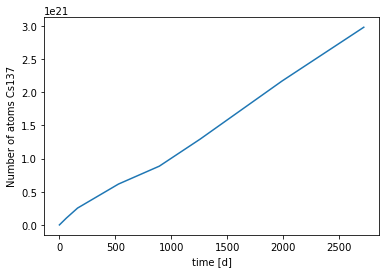

In [9]:
time, cs137 = results.get_atoms("1","Cs137")# I should verify that fuel is material "1"
time /= (24*60*60)
plt.plot(time,cs137,label="Cs137")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Cs137")

Text(0, 0.5, 'Number of atoms Pu239')

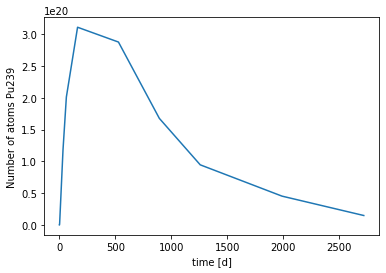

In [10]:
time, Pu239 = results.get_atoms("1","Pu239")

time /= (24*60*60)
plt.plot(time,Pu239,label="Pu239")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Pu239")

Text(0, 0.5, 'Number of atoms')

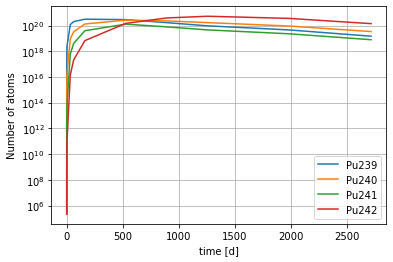

In [11]:
time, Pu240 = results.get_atoms("1","Pu240")
time, Pu241 = results.get_atoms("1","Pu241")
time, Pu242 = results.get_atoms("1","Pu242")
time /= (24*60*60)

plt.semilogy(time,Pu239,label="Pu239")
plt.semilogy(time,Pu240,label="Pu240")
plt.semilogy(time,Pu241,label="Pu241")
plt.semilogy(time,Pu242,label="Pu242")
plt.legend()
plt.grid()
plt.xlabel("time [d]")
plt.ylabel("Number of atoms")

Text(0, 0.5, 'Fraction Pu239')

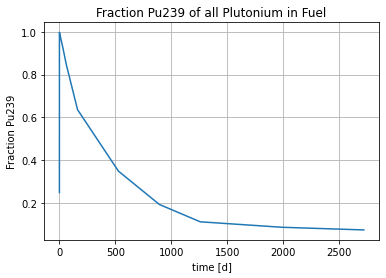

In [12]:
total_pu = Pu239 + Pu240 + Pu241 + Pu242
Pu239_frac = Pu239/total_pu

plt.plot(time,Pu239_frac,label="Fraction Pu239")
plt.grid()
plt.title("Fraction Pu239 of all Plutonium in Fuel")
plt.xlabel("time [d]")
plt.ylabel("Fraction Pu239")